# Snow Geospatial Calculations

This tutorial is the second tutorial in a series of tutorials intended to walk you through downloading, accessing, processing, and visualizing the National Snow and Ice Data Center's (NSIDC) Snow Today's (https://nsidc.org/reports/snow-today) snow cover and albedo datasets. If you haven't already downloaded and explored Snow Today's snow fraction and albedo datasets, please visit the first tutorial, ST_01_Downloading_and_Exploring_Snow_Data. Included in this tutorials are steps to: 

1. Process snow and albedo datasets

    a. Calculate annual and monthly means 

    b. Calculate monthly anomalies 

2.  Convert datasets to alternative file types 

3.  Create an interactive map of raster layers 




## Table of Contents

 ####  [Process Snow Data](#bullet1)
 * [Packages](#package1)
 * [Calculate Monthly Snow Cover Averages](#bullet2)
 * [Calculate Snow Cover Anomalies Per Month Per Year](#bullet5)
 * [Calculate Annual Snow Cover Averages](#bullet4) 
 * [Prepare Snow Cover Data for Format Conversion](#bullet6)
 #### [Process Albedo Data](#bullet7)
 * [Packages](#package2)
 * [Calculate Monthly Albedo Averages](#bullet8)
 * [Calculate Albedo Anomalies Per Month Per Year](#bullet10)
 * [Calculate Annual Albedo Averages](#bullet9) 
 * [Prepare Albedo Data for Format Conversion](#bullet11)
 #### [Convert Datasets to GeoTIFF](#bullet12)
 * [Packages](#package3)
 * [Define Geospatial Inputs](#bullet3)
 * [Convert Array to GeoTIFF](#bullet13)
 * [Convert Stacked Array into Multiple GeoTIFFss](#bullet14)
 * [Transform GeoTIFF to WGS84 Coordinate System](#bullet15)
 * [Transform GeoTIFF to NetCDF File](#bullet16)
 #### [Plot GeoTIFFs Using Leafmap Package](#bullet17)
 * [Packages](#package4)
 


## Processing Snow Cover Data <a class="anchor" id="bullet1"></a>

### Packages <a class="anchor" id="package1"></a>

In [2]:
import glob
from osgeo import gdal
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'osgeo'

## Glob the Datasets

If you haven't already downloaded the snow cover and/or albedo datasets, please go to Tutorial ST_01_Downloading_and_Exploring_Snow_Data. Alternatively, you can manually download datasets from:
https://snow.ucsb.edu/products/SPIRES/Sierra/ 


In [2]:
# As we did the first tutorial, let's "glob" our datasets together. 
# Note: If your datasets do not appear in sequential order i.e., 2001, 2002, etc. use sorted(glob.glob('snow_cover/*.h5'))
snow_cover_ds = glob.glob('snow_cover/*.h5')
snow_cover_ds

['snow_cover\\Sierra2001.h5',
 'snow_cover\\Sierra2002.h5',
 'snow_cover\\Sierra2003.h5',
 'snow_cover\\Sierra2004.h5',
 'snow_cover\\Sierra2005.h5',
 'snow_cover\\Sierra2006.h5',
 'snow_cover\\Sierra2007.h5',
 'snow_cover\\Sierra2008.h5',
 'snow_cover\\Sierra2009.h5',
 'snow_cover\\Sierra2010.h5',
 'snow_cover\\Sierra2011.h5',
 'snow_cover\\Sierra2012.h5',
 'snow_cover\\Sierra2013.h5',
 'snow_cover\\Sierra2014.h5',
 'snow_cover\\Sierra2015.h5',
 'snow_cover\\Sierra2016.h5',
 'snow_cover\\Sierra2017.h5',
 'snow_cover\\Sierra2018.h5',
 'snow_cover\\Sierra2019.h5']

## Calculate Monthly Snow Cover Averages<a class="anchor" id="bullet2"></a>

Before we calculate the monthly average of snow cover for all our data, let's try and calculate the average for a single month in a single year.

In [8]:
# Get subdatasets of first snow fraction dataset ('Sierra2001.h5').
sierra_snow_2001 = gdal.Open(snow_cover_ds[0], gdal.GA_ReadOnly).GetSubDatasets()

# Pull divisor from dataset (100)
snow_divisor = int(gdal.Open(snow_cover_ds[0], gdal.GA_ReadOnly).GetMetadata()['Grid_MODIS_GRID_500m_snow_fraction_divisor'])

# (datasets[3] is to choose the 4th dataset in the subdirectory (i.e., snow fraction). 
# The second bracket [0] is needed to open the dataset.
snow_data_2001 = gdal.Open(sierra_snow_2001[3][0])

# Changes the selected dataset into an array.
snow_data_array_2001 = snow_data_2001.ReadAsArray()

# Converts the variables to 'float' to allow us to convert NA values (255) to nans
snow_data_float_2001 = snow_data_array_2001.astype('float')
snow_data_float_2001[snow_data_float_2001 == 255] = np.nan

snow_data_float_2001 = snow_data_float_2001/snow_divisor

# Transpose the data so that the 'days' dimension is the last one in our matrix. 
snow_data_transposed_2001 = np.transpose(snow_data_float_2001)

np.shape(snow_data_transposed_2001)

(1841, 1334, 365)

Now that we've filtered out NA values and transposed our data, let's take the monthly mean of October, the first month in our dataset. 
(Recall from the first tutorial that the datasets follow the water year, which starts on October-1 of the year prior and goes to September 30 of the next year.) 

In [9]:
# Let's test to see if we can create a range of dates starting at '2000-10-01', the first date of our first year.

# First, we'll make a string of the first day of our dataset (Sierra2001.h5)

start_date = (str(2000) + '-10-01')

# Next, we'll make a string of the last day in our dataset since our datasets always end on September 30th of the water year.
# Notice that we're adding 1 to our year since water years count from the year prior.

end_date = (str(int(2000) + 1) + '-09-30')

# Creates a list of datetimes based on each year in our dataset.
# start = start of the water year
# end = end of water year
# freq = frequency of series (in this case days)
# freq = "d" outputs the values in year-month-day format. 
# For additional information regarding datetime types, go to: https://pandas.pydata.org/pandas-docs/version/0.15/timeseries.html

year_month_day = pd.Series(pd.date_range(start = start_date, end = end_date, freq="d"))

# Now we have a list of dates that span the same length as our dataset. We'll be using the index position, (i.e., what row dates are located between) to subset our dataset.
# Here, we're subsetting our list for month 1, or January in this case.  

month = year_month_day[year_month_day.dt.month == 1]

# Now for a little Python trickery-- since our year_month_day variable starts and ends at the same time as our dataset(e.g., 20xx-10-01 to 20xx-09-03), 
# we can use the subset of the months of our dataset by the index of the list.
# However, as Python counts from 0 onward, and we are interested in the physical values for dates, 
# we need to add 1 to our first and last month values (e.g., change 0-30 to 1-31).
# This results in two variables that coincide with each month's first and last day indexes in our dataset.

first_day_month = month.index[0].astype('int') + 1 
print(first_day_month)
#[-1] outputs the last value of list 
last_day_month = month.index[-1].astype('int') + 1
print(last_day_month)

93
123


Here we see that January the 'first_day_month' of January aligns with index position 93, while the 'last_day_month' variable aligns with index number 123. This is because our dataset starts from October 2000. As such, our dataset 'days' counts from 0 onwards. October aligns with index positions 0-31, November aligns with 32-61, December with 62-92, etc. 


Now that we can select the first and last day of any month, we can subset our datasets by days between those values and then take the mean of those days to get the monthly snow cover average.  

In [10]:
# Create an empty list to append our calculated values to. 

month_list = []

# Here, we're subsetting our dataset the first and last day of the selected month.

month_len = snow_data_transposed_2001[:,:,first_day_month:last_day_month]

# Takes the mean of each cell in x and y dimensions over the specific month. 
# Axis 2 aligns with our 3rd dimension, which are days in this case.  
mean = np.nanmean(month_len, axis = 2)

# Appends the values to an empty list.
month_list.append(mean)

# Converts list to an array. 
month_array = np.array(month_list)


# We now have a 3 dimensional dataset where the first dimension is month and second and third are x and y dimensions. 
np.shape(month_array)

C:\Users\rmunn\AppData\Local\Temp\ipykernel_18080\4203345156.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(month_len, axis = 2)


(1, 1841, 1334)

Great--we now have a monthly mean for a single month. Let's try and for loop through each month of each year. 

### For Loop Through Each Year

In [11]:
# Create an empty list to append our values to. 
snow_monthly_means_list = []
for i in range(len(snow_cover_ds)):
    # Get subdatasets of first snow fraction dataset ('Sierra2001.h5').
    datasets = gdal.Open(snow_cover_ds[i], gdal.GA_ReadOnly).GetSubDatasets()

    # (sds[3] is to choose the 4th dataset in the subdirectory (i.e., snow fraction). 
    # The second bracket [0] is needed to open the dataset.
    snow_data = gdal.Open(datasets[3][0])

    # Changes the selected dataset into an array.
    snow_data_array = snow_data.ReadAsArray()

    # Converts the variables to 'float' to allow us to convert NA values (255) to nans
    snow_data_float=snow_data_array.astype('float')
    snow_data_float[snow_data_float == 255] = np.nan

    # Divide data by the divisor (100)
    snow_data_float = snow_data_float / snow_divisor
    
    # Transpose the dataset 
    snow_data_transposed = np.transpose(snow_data_float)
    
    # Make a variable for the starting year of each water year.
    year =  i + 2000

    # Creates a variable for the end date in the water year. 
    start_date = (str(year) + '-10-01')
    end_date = (str(int(year) + 1) + '-09-30')

    # Creates a list of datetimes based on each year in our dataset.
    # start = start of the water year
    # end = end of water year
    # freq = frequency of series (in this case days)
    year_month_day = pd.Series(pd.date_range(start = start_date, end = end_date, freq="d"))
    
    #Need to create an empty list to append our nest for loop values to. 
    new_list = []
    
    # For loop to calculate the mean for each month per year. 
    for j in range (1, 13):
        # Subset the date year we just created based on month each month. 
        month = year_month_day[year_month_day.dt.month == j]

        # Since our year_month_day variable starts and ends at the same time as our dataset(e.g., 20xx-10-01 to 20xx-09-03), we can use the subset the months our dataset by the lists index.
        # However, as Python counts from 0 onward, and we are interested in the physical values for dates, we need to add 1 to our first and last month values (e.g., change 0-30 to 1-31)
        first_day_month = month.index[0].astype('int') + 1 
        last_day_month = month.index[-1].astype('int') + 1
        
        # Subset our yearly data by each months values.
        month_len = snow_data_transposed[:,:,first_day_month:last_day_month]

        # Now we can take the mean of year month, since our 3rd dimension is the subset of days for that month.
        # This will reduce our dimensions down to 2, since we're taking the average over a month. 
        mean = np.mean(month_len, axis = 2)
        
        # Append monthly mean values to list for a single year. 
        new_list.append(mean)

    # Append single year lists to yearly list, which will contain all the monthly means per year. 
    snow_monthly_means_list.append(new_list)
    
# Converts list to array. 
snow_monthly_mean_per_year_array = np.array(snow_monthly_means_list)
np.shape(snow_monthly_mean_per_year_array)

(19, 12, 1841, 1334)

Here we see that our final product is a four dimensional array, where the first dimension is years, the second dimension is months, and the third and fourth dimensions are x and y dimensions. 

## Calculate Snow Cover Anomalies Per Month Per Year<a class="anchor" id="bullet5"></a> 

Now that we have successfully calculated the monthly averages of snow cover, let's try calculate the monthly snow cover anomalies. Anomalies, in this instance, are the difference of monthly averages of a single dataset from the monthly average of all datasets. This can helpful if you're trying to compare how a single months snow cover compares the trend in snow cover for a given month. 

In [10]:
# Note: February's monthly average is slightly skewed towards leap years since we are not taking a weighted mean

# Since we already have the mean of each month per year stored in a 4d array (year, month, ydim, xdim), we can take the mean of the year column (axis 0), since each year column
# stores a 3d array for each year. This function will effectively take the mean of each month, ydim, and xdim to end up with a single 3d array. 
mean_of_months = np.mean(snow_monthly_mean_per_year_array, axis = 0)

# Create empty list to put anomalies in.
monthly_anomalies = []

# For loop through each year in the dataset 
# [:] selects the first dimension in our 4d dataset, which is years, in this case. 
for i in range(len(snow_monthly_mean_per_year_array[:])):
    
    # Creates a subsetted dataset of each year
    selected_anomaly_year = snow_monthly_mean_per_year_array[i]
    
    # Create an empty list to append our monthly anomalies to
    month_anomalies_list = []
    
    # For loop through each month of each year (12)
    # [:] selects the dimension in our 3d dataset, which is months, in this case. 
    for j in range(len(selected_anomaly_year[:])):
       
        # Subtract our monthly means from our annual means for each month
        monthly_anom = selected_anomaly_year[j] - mean_of_months[j]
       
        # Append list with the calculated monthly anomalies.
        month_anomalies_list.append(monthly_anom)

    # Append list with list comprised of monthly anomalies
    # Final list values will be the same shape as the monthly_means_per_year dataset since we are calculating monthly anomalies for each year.
    monthly_anomalies.append(month_anomalies_list)

# Transform to list to arrays
snow_anom_array = np.array(monthly_anomalies)

np.shape(snow_anom_array)


(19, 12, 1841, 1334)

Notice that the shape our dataset the same as our monthly means dataset. This is because we calculated the monthly anomalies of each month for each year. 

## Calculate Annual Snow Cover Averages<a class="anchor" id="bullet4"></a> 

In general, snow is a seasonal phenomenon. As such, if we were to take the annual average snow cover of the Sierras, we'd be left with an array with little to snow present (since at least half the year snow would not be present). Therefore, we will calculate the average snow cover of non-zero values. 

If you'd like to calculate the true annual snow cover average, please hash out 'snow_data_float[snow_data_float == 0 ] = np.nan' in the code chunk below. 

In [ ]:
# Create an empty list to append our yearly means to
snow_year_list = []

for i in range(len(snow_cover_ds)):
    
    # Get subdatasets of first snow fraction dataset ('Sierra2001.h5').
    datasets = gdal.Open(snow_cover_ds[i], gdal.GA_ReadOnly).GetSubDatasets()

    # (sds[3] is to choose the 4th dataset in the subdirectory (i.e., snow fraction). 
    # The second bracket [0] is needed to open the dataset.
    snow_data = gdal.Open(datasets[3][0])

    # Changes the selected dataset into an array.
    snow_data_array = snow_data.ReadAsArray()

    # Converts the variables to 'float' to allow us to convert NA values 255 to nans
    # We'll also convert 0s to nans to calculate the average of non-zero values
    snow_data_float=snow_data_array.astype('float')
    snow_data_float[snow_data_float == 255] = np.nan
    
    # If you'd like to calculate the true annual mean of snow cover, hash out (add #) in front of the code chunk below. 
    snow_data_float[snow_data_float == 0 ] = np.nan

    # Divide data by the divisor (100)
    snow_data_float = snow_data_float/snow_divisor
    
    # Transpose our dataset, as we did in the code chunks above
    snow_data_transposed = np.transpose(snow_data_float)
    
    # The dimensions of our data is now ydim, xdim, days. 
    # Now, we can take the mean by our 3rd dimension to find the non-zero average of annual values of snow.
    annual_snow = np.nanmean(snow_data_transposed, axis = 2)
    
    # Append yearly values to a list. 
    snow_year_list.append(annual_snow)

# Convert list to an array. 
snow_year_array = np.array(snow_year_list)

np.shape(snow_year_array)

Now we're left with a 3 dimensional dataset where the dimensions are: years, x dim, y dim. 

## Prepare Snow Data for Format Conversion <a class="anchor" id="bullet6"></a> 

Now that we have a dataset of monthly means, annual averages, and monthly anomalies, we can prepare our dataset for format conversions. Here we'll subset out all 0 values from our dataset and learn how to select a specific year/month. We subset out the 0 values so that when we convert our data, we'll be left with a raster layer where only snow values are present. This allows use to see the basemap below the area of our raster layer. 

We'll select three arrays to convert to GeoTIFFs and NetCDF formats: 

* mean snow cover of month one of year one;

* snow cover anomaly of month one of year one; and  

* mean snow cover for year one.

Note: To convert stacked arrays into stacked geoTIFFs, we need to transposed our datasets so that our dimensions are ordered as: x dimension, y dimension, time. 

### Process Monthly Averages

In [21]:
# We need to first convert our array that we calculated above to 'float'.

snow_monthly_mean_per_year_float = snow_monthly_mean_per_year_array.astype('float')

# Next, he convert all 0s to nan values
snow_monthly_mean_per_year_float[snow_monthly_mean_per_year_float== 0] = np.nan

# Last, we convert our dataset back in array
snow_cover_monthly_mean = np.array(snow_monthly_mean_per_year_float)


# Select the first year of our dataset.
snow_year_one = snow_cover_monthly_mean[0,:,:,:]

# Select the first month of the first year 
snow_year_one_month_one = snow_year_one[0,:,:]


### Process Snow Cover Monthly Anomalies

Here we do the same steps as we did with the monthly averages. 

In [22]:
#Let's do the same for our anomaly dataset 

# We need to first convert our array that we calculated above to 'float'.
snow_anom_float = snow_anom_array.astype('float')

# Next, he convert all 0s to nan values
snow_anom_float[snow_anom_float== 0] = np.nan

# Last, we convert our dataset back in array
snow_anom_mean = np.array(snow_anom_float)

#Select the first year of the anomaly dataset. 
snow_year_one_anom = snow_anom_mean[0,:,:,:]

# Select the first month of the first year
snow_year_one_month_one_anom = snow_year_one_anom[0,:,:]

### Process Annual Snow Cover Averages

Since we've already subsetted out 0s in our annual calculations, all we need to do is select the year we're interested in and transpose our data. 

In [15]:
# Select first year of the dataset 
annual_snow_year_one = snow_year_array[0,:,:]

# Process Albedo Data<a class="anchor" id="bullet7"></a> 
Next, we'll run through the same steps as we did above, but for the albedo datasets. If you haven't already, please go to the first tutorial to learn how to download the albedo datasets. 

Alternatively, to manually download Sierra albedo datasets, please visit: https://snow.ucsb.edu/products/SPIRES/SierraAlbedo/

## Packages<a class="anchor" id="package2"></a> 


In [1]:
import glob
from osgeo import gdal
import numpy as np
import pandas as pd

## Glob the datasets together

In [12]:
# As we did with snow cover, let's "glob" our datasets together. 
# Note: If your datasets do not appear in sequential order i.e., 2001, 2002, etc. use: sorted(glob.glob('albedo/*.h5'))
albedo_ds = glob.glob('albedo/*.h5')
albedo_ds

['albedo\\SierraAlbedo2001.h5',
 'albedo\\SierraAlbedo2002.h5',
 'albedo\\SierraAlbedo2003.h5',
 'albedo\\SierraAlbedo2004.h5',
 'albedo\\SierraAlbedo2005.h5',
 'albedo\\SierraAlbedo2006.h5',
 'albedo\\SierraAlbedo2007.h5',
 'albedo\\SierraAlbedo2008.h5',
 'albedo\\SierraAlbedo2009.h5',
 'albedo\\SierraAlbedo2010.h5',
 'albedo\\SierraAlbedo2011.h5',
 'albedo\\SierraAlbedo2012.h5',
 'albedo\\SierraAlbedo2013.h5',
 'albedo\\SierraAlbedo2014.h5',
 'albedo\\SierraAlbedo2015.h5',
 'albedo\\SierraAlbedo2016.h5',
 'albedo\\SierraAlbedo2017.h5',
 'albedo\\SierraAlbedo2018.h5',
 'albedo\\SierraAlbedo2019.h5']

## Calculate Monthly Albedo Averages<a class="anchor" id="bullet8"></a> 

Here we'll go through the same process as we did with calculating monthly average snow cover. 

Recall from the first tutorial that albedo values have a divisor of 10000. Albedo is generally reported from 0-1 (0 being no surface reflection and 1 being 100% reflection). To get albedo in the correct units, we'll need to divide each of our monthly values by 10000. Unfortunately, unlike snow cover, the albedo divisor is not easily callable from metadata. So for simplicity, we'll explicitly define the divisor (10000) above the for loop. 


In [14]:
# Create an empty list to append values to
albedo_monthly_mean_list = []

albedo_divisor = 10000

# Select a range of values based on the number of datasets
for i in range(len(albedo_ds)):
    # Open albedo sub dataset
    albedo_data = gdal.Open(albedo_ds[i], gdal.GA_ReadOnly)

    # Change the selected dataset into an array.
    albedo_data_array = albedo_data.ReadAsArray()

    albedo_data_float = albedo_data_array.astype('float')
    
    # Convert na values to nans
    albedo_data_float[albedo_data_float == 65535] = np.nan

    albedo_data_float = albedo_data_float/albedo_divisor

    # Transpose albedo data
    albedo_data_transposed = np.transpose(albedo_data_float)
    
    # Make a variable for the starting year of each water year.
    year =  i + 2000

    # Creates a variable for the first date in the water year. 
    start_date = pd.to_datetime(str(year) + '-10-01')
    end_date = pd.to_datetime(str(int(year) + 1) + '-09-30')

    # Creates a list of datetimes based on each year in our dataset.
    albedo_year_month_date = pd.Series(pd.date_range(start = start_date, end = end_date, freq="d"))

    # Need to create an empty list to append our nested for loop values to. 
    new_list = []

    # For loop to calculate the mean for each month per year.
    for j in range (1, 13):

        # Subset the date year based on month.
        month = albedo_year_month_date[albedo_year_month_date.dt.month == j]
        
        # Select the first and last day of the month based on our lists index values. 
        # Need to add one to each value since Python counts from 0 onward. 
        first_day_month = month.index[0].astype('int') + 1 
        last_day_month = month.index[-1].astype('int') + 1
        
        # Subset dataset by each month.
        month_len = albedo_data_transposed[:,:,first_day_month:last_day_month]

        # Take the mean of each month per year. 
        mean = np.mean(month_len, axis = 2)

        # Append mean values to list per year. 
        new_list.append(mean)

    # Append year lists to empty list. 
    albedo_monthly_mean_list.append(new_list)

# Converts list to array. 
albedo_monthly_mean_array = np.array(albedo_monthly_mean_list)
np.shape(albedo_monthly_mean_array)

(19, 12, 1841, 1334)

## Calculate Albedo Anomalies Per Month Per Year <a class="anchor" id="bullet10"></a> 

Similar to snow cover, let's be calculate albedo anomalies for each month in each year. 

In [15]:
# Takes the mean of each monthly mean
# Note: to get true mean (weighted mean), we would need to take the mean of the cumulative days of a single month, then divide by the number of days. 
# However, since the sample size only varies by one day every four years (leap years), this will give us near identical values. 
month_mean_albedo = np.mean(albedo_monthly_mean_array, axis = 0)
np.shape(month_mean_albedo)


# Create empty list to put values in 
albedo_monthly_anom = []

# Select range in years (1, 19)
for i in range(len(albedo_monthly_mean_array[:])):

   # albedo_divisor_array[i] chooses the first year in the dataset since the first dim is year
    albedo_year_anom = albedo_monthly_mean_array[i]

    # Create an empty list to append nest for loop values to.
    sub_list = []

    # select range in months per year(1, 12)
    for j in range(len(albedo_year_anom[:])):

        # albedo_year_anom[j] chooses the first mean month of the selected year
        # Since we've already calculated the annual monthly mean over 19 years, we can subtract each 
        # monthly mean from the annual monthly mean to see how each years monthly means deviate from the annual monthly mean   
        month_anom = albedo_year_anom[j] - month_mean_albedo[j]
        
        # Append monthly anomalies to the list 
        sub_list.append(month_anom)

    # Append monthly anomalies per year to the list
    albedo_monthly_anom.append(sub_list)

# Convert anomaly list to an array
albedo_anom_array = np.array(albedo_monthly_anom)

## Calculate the Annual Albedo Averages<a class="anchor" id="bullet9"></a> 

Similar to snow cover, we'll calculate the non-zero albedo averages per each year. 

In [17]:
# Create an empty list to append our yearly means to
albedo_year_list = []

# We'll divide our values by this number. 
albedo_divisor = 10000

# Select a range of values based on the number of datasets
for i in range(len(albedo_ds)):
    
    # Open albedo sub dataset
    albedo_data = gdal.Open(albedo_ds[i], gdal.GA_ReadOnly)

    # Change the selected dataset into an array.
    albedo_data_array = albedo_data.ReadAsArray()

    albedo_data_float = albedo_data_array.astype('float')
    
    # Convert na values to nans
    albedo_data_float[albedo_data_float == 65535] = np.nan

    # If you'd like to calculate the true annual mean of albedo, hash out (add #) in front of the code chunk below. 
    albedo_data_float[albedo_data_float == 0 ] = np.nan

    # Divide data by the divisor 
    albedo_data_float = albedo_data_float/albedo_divisor

    # Transpose our dataset, as we did in the code chunks above
    albedo_data_transposed = np.transpose(albedo_data_float)
    
    # The dimensions of our data is now ydim, xdim, days. 
    # Now, we can take the mean by our 3rd dimension to find the non-zero average of annual values of albedo.
    annual_albedo = np.nanmean(albedo_data_transposed, axis = 2)
    
    # Append yearly values to a list. 
    albedo_year_list.append(annual_albedo)

# Convert list to an array. 
albedo_year_array = np.array(albedo_year_list)

np.shape(albedo_year_array)

C:\Users\rmunn\AppData\Local\Temp\ipykernel_18080\3878712744.py:32: RuntimeWarning: Mean of empty slice
  annual_albedo = np.nanmean(albedo_data_transposed, axis = 2)


(19, 1841, 1334)

## Process Albedo Data for Format Conversion <a class="anchor" id="bullet11"></a> 

Similar to snow cover, we'll select three arrays to convert to GeoTIFFs and NetCDF formats: 

* mean albedo of month one of year one;

* albedo anomaly of month one of year one; and  

* mean albedo for year one.

### Process Monthly Albedo Data

In [24]:
# We need to first convert our array that we calculated above to 'float'.
albedo_monthly_float = albedo_monthly_mean_array.astype('float')

# Next, he convert all 0s to nan values
albedo_monthly_float[albedo_monthly_float== 0] = np.nan

# Last, we convert our dataset back in array
albedo_monthly_mean = np.array(albedo_monthly_float)

# Select the first year of our dataset.
albedo_year_one = albedo_monthly_mean[0,:,:,:]

# Select the first month of the first year 
albedo_year_one_month_one = albedo_year_one[0,:,:]

### Process Monthly Anomaly Albedo Data

In [27]:
#Let's do the same for our anomaly dataset 

# We need to first convert our array that we calculated above to 'float'.
albedo_anom_float = albedo_anom_array.astype('float')

# Next, he convert all 0s to nan values
albedo_anom_float[albedo_anom_float== 0] = np.nan

# Last, we convert our dataset back in array
albedo_anom_mean = np.array(albedo_anom_float)

#Select the first year of the anomaly dataset. 
albedo_year_one_anom = albedo_anom_mean[0,:,:,:]

# Select the first month of the first year
albedo_year_one_month_one_anom = albedo_year_one_anom[0,:,:]

### Process Annual Albedo Data

In [43]:
# Select first year of the dataset 
annual_albedo_year_one = albedo_year_array[0,:,:]

# Convert Datasets <a class="anchor" id="bullet12"></a> 

Now that we have successfully processed and subsetted both the snow cover and albedo datasets, we're ready to convert the arrays into GeoTIFFs and NetCDF formats. Converting snow cover and albedo data to GeoTIFFs allows us to embed geospatial information into the datasets. This allows mapping softwares, such as QGIS and ArcGIS, as well as Python mapping packages such as leafmap to interpret where the data is spatially. 

(See tutorial one for additional information regarding dataset geospatial information)

## Packages<a class="anchor" id="package3"></a>

In [105]:
from osgeo import gdal 
import os 
import rioxarray 
from rasterio.plot import show
import rasterio

## Define Geospatial Inputs <a class="anchor" id="bullet3"></a> 

In [55]:
# Note: Since relevant Geospatial Metadata is the same for snow cover and albedo, we can use the same inputs for functions below. 

# x dimension of array
xdim = snow_data_array.shape[1]

# y dimension of array
ydim = snow_data_array.shape[2]

# Projection data of sample GeoTiff
# Note: No projection information is provided in the dataset metadata. As such, 
# projection data was pulled from: https://spatialreference.org/ref/sr-org/8568/html/
projection = 'PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",34],PARAMETER["standard_parallel_2",40.5],PARAMETER["false_easting",0],PARAMETER["false_northing",-4000000],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

# Transformation data of array
# Pulls referencing matrix from h5 file.
# The referencing matrix is stored as string, so we need to split each value, the rearrange into the correct positions

ref_matrix_meta = snow_data.GetMetadata()['Grid_MODIS_GRID_500m_ReferencingMatrix'].split()
referencing_matrix = [int(ref_matrix_meta[2]), int(ref_matrix_meta[1]), int(ref_matrix_meta[0]), int(ref_matrix_meta[5]), int(ref_matrix_meta[4]), int(ref_matrix_meta[3])]

## Convert Array to GeoTIFF <a class="anchor" id="bullet13"></a> 

This function allows us to covert a single array into a single raster layer with Albers Conical Equal Area projection information. 

In [87]:
# Define the variables needed to get the function to run. 
def SingleGeoTIFF(raster_name, data, height, width, geotransform, wkt):
    # Set driver to 'GTiff' for Geotiffs
    driver = gdal.GetDriverByName('GTiff')
    # Create a GeoTIFF, where:
    # name = raster name,
    # width = 1st dim,
    # height = 2nd dim,
    # 1 = 3rd dim (effectively making it a two-dimensional object),
    # GDT_Float32 = number format 
    dataset = driver.Create(
        raster_name,
        width,
        height,
        1,
        gdal.GDT_Float32)

    dataset.SetGeoTransform((
     geotransform))

    dataset.SetProjection(wkt)
    dataset.GetRasterBand(1).WriteArray(data)
    dataset.FlushCache()  # Write to disk.
    return dataset, dataset.GetRasterBand(1) 

In [88]:
# Now that we've defined our function, we can input our variables and output a GeoTIFF. 
SingleGeoTIFF('snow_year_one_month_one.tif', snow_year_one_month_one, ydim, xdim, referencing_matrix, projection)

(<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000153DA370DB0> >,
 <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x00000153D3EA5840> >)

Now that we've successfully created a geoTiff, let's see what it looks like. 

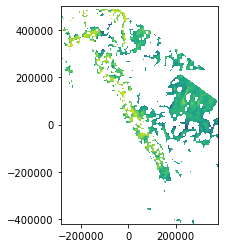

<AxesSubplot:>

In [104]:
# Read in TIF
snow_vis = r'snow_year_one_month_one.tif'
# Use rasterio to open newly created TIF 
img = rasterio.open(snow_vis)
# Display image
show(img)

The shape of the image looks correct, but the x and y dimensions are still in Universal Transverse Mercator coordinate system (UTM), meaning that the values are being displayed in meters. Below, we'll convert to longitude and latitude for easier interpretability. 


## Convert Stacked Array into Multiple GeoTIFFs <a class="anchor" id="bullet14"></a> 

Now that we can convert a single layer into a single GeoTIFF, let's use the same function to for loop through the mean months of a single year. The output should be 12 geoTIFFs--one for each mean month of the year.

In [69]:
# Define the path you want your TIFFs to be downloaded to 
snow_year_one_transposed = np.transpose(snow_year_one, (1,2,0))
path = '2001/months'
for i in range(len(snow_year_one)):
    # Define name of each tif
    dest = ('month_' + str(i + 1) + '_year_2001.tif') 
    name = os.path.join(path, dest)
    data = snow_year_one_transposed[:,:,i]
    SingleGeoTIFF(name, data, ydim, xdim, referencing_matrix, projection)

## Convert Stacked Array to GeoTIFF <a class="anchor" id="bullet15"></a> 

Now, let's convert a stacked array into a stacked GeoTIFF. We'll again use snow year one as our test array. 

In [84]:
def StackedGeoTIFF(name, data, geo_transform, projection):
    
    driver = gdal.GetDriverByName('GTiff')

    DataSet = driver.Create(name, data.shape[2], data.shape[1], data.shape[0], gdal.GDT_Float32)
    DataSet.SetGeoTransform(geo_transform)
    DataSet.SetProjection(projection)
    for i, image in enumerate(data, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
    DataSet.FlushCache()
    return name

In [71]:
StackedGeoTIFF('year_one_stack.tif', snow_year_one, referencing_matrix, projection)

'year_one_stack.tif'

## Transform GeoTIFFS to WGS84 Coordinate System <a class="anchor" id="bullet15"></a> 

Most Python mapping packages require GeoTIFFs to be in World Geodetic System 84 (WGS84). Let's convert our newly created geoTIFFs to WGS84 format. 

In [91]:

# Change the following variables to the file you want to convert (inputfile)
# and what you want to name your output file (outputfile)
inputfile = "snow_year_one_month_one.tif"
outputfile = "wgs_snow_year_one_month_one.tif"

ds = gdal.Warp(outputfile, inputfile, dstSRS="+proj=longlat +datum=WGS84 +no_defs", dstNodata = 0)

In one line of code we are able to convert our geoTIFFs to WGS84 projection. Below, we'll use this GeoTIFF to plot on an interactive map using the leafmap package. Let's see what it looks like if were to plot it now. 

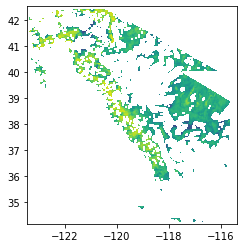

<AxesSubplot:>

In [99]:
# Read in TIF
snow_vis = r'wgs_snow_year_one_month_one.tif'
# Use rasterio to open newly created TIF 
img = rasterio.open(snow_vis)
# Display image
show(img)

Notice that the shape of our image as changed slightly and our x and y dimensions are now in lat/long. Below, we'll try plotting this on an interactive map. 

## Transform GeoTIFF to NetCDF File <a class="anchor" id="bullet16"></a> 

We can just as easily transform our GeoTIFFs to NetCDF files using the '.to_netcdf' function in the rasterio package.

In [92]:
tiff = rioxarray.open_rasterio('wgs_snow_year_one_month_one.tif')
tiff.to_netcdf('wgs_snow_year_one_month_one.nc')

# Plot Rasters Using Leafmap <a class="anchor" id="bullet17"></a> 

Now that have created geoTIFFs with WGS84 projection, we're ready to plot our rasters onto an interactive map using the leafmap Python package.

## Packages<a class="anchor" id="package4"></a> 

In [ ]:
import leafmap 

In [ ]:
# layer_one = ("wgs_test4.tif")
# m = leafmap.Map(draw_control=False, layers_control=True)
# m.add_raster(input_one, colormap='terrain', layer_name='layer_one')
# m

## What's Next

In the next tutorial (ST_03_Interactive_Charts), we'll be calculating total snow cover extent and albedo percentages for each year, performing basic statistical analysis of each dataset, and developing interactive figures to compare yearly snow cover and albedo percentages.


For additional information regarding how snow and albedo datasets were created, please visit: https://nsidc.org/reports/snow-today